In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imblearn is not available. SMOTE will not be used.")

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)

In [9]:

df = pd.read_csv('..\\..\\data\\csv\\FY_2022-2025.csv')
# Cleaning
df.columns = df.columns.str.strip()

In [ ]:
def run_advanced_model_pipeline(df: pd.DataFrame, condition_name: str):
    """
    This function runs the full advanced modeling pipeline for a given condition.

    Args:
        df (pd.DataFrame): The input DataFrame containing all the data.
        condition_name (str): The name of the condition to process (e.g., 'Condition A').
    """
    print(f"\n--- Starting Advanced Modeling Pipeline for {condition_name} ---")

    # Define target and error columns based on the condition name
    target_col = f'Penalty indicator for {condition_name}'
    err_col = f'ERR for {condition_name}'
    median_err_col = f'Peer group median ERR for {condition_name}'

    df_condition = df.copy() #so i don't modify the original DataFrame

    # --- Data Preprocessing ---
    print("\n--- Data Preprocessing ---")

    initial_rows = len(df_condition)
    df_condition.dropna(subset=[target_col, err_col, median_err_col], inplace=True)
    if df_condition.empty:
        print(f"Error: No data remaining after dropping NaNs for {condition_name}. Exiting pipeline.")
        return
    print(f"Dropped {initial_rows - len(df_condition)} rows with missing values in key columns.")

    # target column to numeric (0 or 1)
    df_condition[target_col] = df_condition[target_col].apply(lambda x: 1 if x == 'Y' else 0)
    print(f"Target column '{target_col}' converted to numeric (0/1).")

    # Base features for modeling
    base_features = [
        'Payment adjustment factor', 'Payment reduction percentage', 'Dual proportion',
        'Peer group assignment', 'Neutrality modifier'
    ]

    cols_to_convert_numeric = base_features + [err_col, median_err_col]

    
    for col in cols_to_convert_numeric:
        if col in df_condition.columns:
            df_condition[col] = pd.to_numeric(df_condition[col], errors='coerce')
            if df_condition[col].isnull().any():
                mean_val = df_condition[col].mean()
                df_condition[col].fillna(mean_val, inplace=True)
                print(f"Column '{col}' converted to numeric and NaNs filled with mean ({mean_val:.2f}).")
        else:
            print(f"Warning: Feature column '{col}' not found in DataFrame for {condition_name}. Skipping conversion.")

    # Feature Engineering 
    print("\n--- Feature Engineering ---")

    # Create 'ERR_vs_median' feature
    # Ensure both components exist and are numeric before attempting subtraction
    if err_col in df_condition.columns and median_err_col in df_condition.columns:
        df_condition['ERR_vs_median'] = df_condition[err_col] - df_condition[median_err_col]
        print("New feature 'ERR_vs_median' created.")
        final_features = base_features + ['ERR_vs_median']
    else:
        print(f"Warning: Could not create 'ERR_vs_median' as '{err_col}' or '{median_err_col}' missing.")
        final_features = base_features # Fallback to base features if ERR_vs_median can't be created

    # data split
    X = df_condition[final_features]
    y = df_condition[target_col]

    # target variable has enough classes for stratification?
    if len(y.unique()) < 2:
        print(f"Error: Target variable '{target_col}' has only one class after preprocessing. Cannot split data for modeling. Exiting.")
        return

    # training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(f"Data split into training (70%) and testing (30%) sets. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

    # SMOTE
    if SMOTE_AVAILABLE:
        print("\nApplying SMOTE to balance the training data...")

        if y_train.value_counts().min() > 0: # Ensure minority class is present
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            print(f"Class distribution after SMOTE:\n{y_train_resampled.value_counts()}")
        else:
            print("SMOTE not applied: Minority class not present in training data or no imbalance.")
            X_train_resampled, y_train_resampled = X_train, y_train
    else:
        print("\nSMOTE not available, proceeding with original imbalanced data.")
        X_train_resampled, y_train_resampled = X_train, y_train

    
    print("\n--- Starting Model Training and Tuning ---")

    # models and their hyperparameters for tuning
    models = {
        'RandomForest': RandomForestClassifier(random_state=42,
                                             class_weight='balanced' if not SMOTE_AVAILABLE else None),
        'GradientBoosting': GradientBoostingClassifier(random_state=42)
    }

    # hyperparameter grids for tuning
    param_grid = {
        'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
        'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
    }

    # Loop through each model for tuning and evaluation
    for model_name, model in models.items():
        print(f"\n--- Tuning and Evaluating {model_name} for {condition_name} ---")

        # Using GridSearchCV to find the best model parameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name],
                                   cv=3, n_jobs=-1, scoring='roc_auc', verbose=0) # verbose set to 0 for cleaner output
        grid_search.fit(X_train_resampled, y_train_resampled)

        best_model = grid_search.best_estimator_
        print(f"Best Parameters found for {model_name}: {grid_search.best_params_}")
        print(f"Best ROC AUC score on validation sets: {grid_search.best_score_:.2f}")

        
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        print(f"\n--- Final Evaluation for Tuned {model_name} on Test Set ---")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['No Penalty', 'Penalty']))

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Penalty', 'Penalty'], yticklabels=['No Penalty', 'Penalty'])
        plt.title(f'Confusion Matrix for {model_name} ({condition_name})')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout() 
        plt.show() 

        print(f"--- End of {model_name} Pipeline for {condition_name} ---")

    print(f"\n--- Advanced Modeling Pipeline for {condition_name} Completed ---")



--- Starting Advanced Modeling Pipeline for AMI ---

--- Data Preprocessing ---
Dropped 311 rows with missing values in key columns.
Target column 'Penalty indicator for AMI' converted to numeric (0/1).
Column 'ERR for AMI' converted to numeric and NaNs filled with mean (1.00).

--- Feature Engineering ---
New feature 'ERR_vs_median' created.
Data split into training (70%) and testing (30%) sets. X_train shape: (6126, 6), X_test shape: (2626, 6)

Applying SMOTE to balance the training data...
Class distribution after SMOTE:
Penalty indicator for AMI
1    4258
0    4258
Name: count, dtype: int64

--- Starting Model Training and Tuning ---

--- Tuning and Evaluating RandomForest for AMI ---
Best Parameters found for RandomForest: {'max_depth': 20, 'n_estimators': 200}
Best ROC AUC score on validation sets: 0.98

--- Final Evaluation for Tuned RandomForest on Test Set ---
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

  No Penalty       0.95

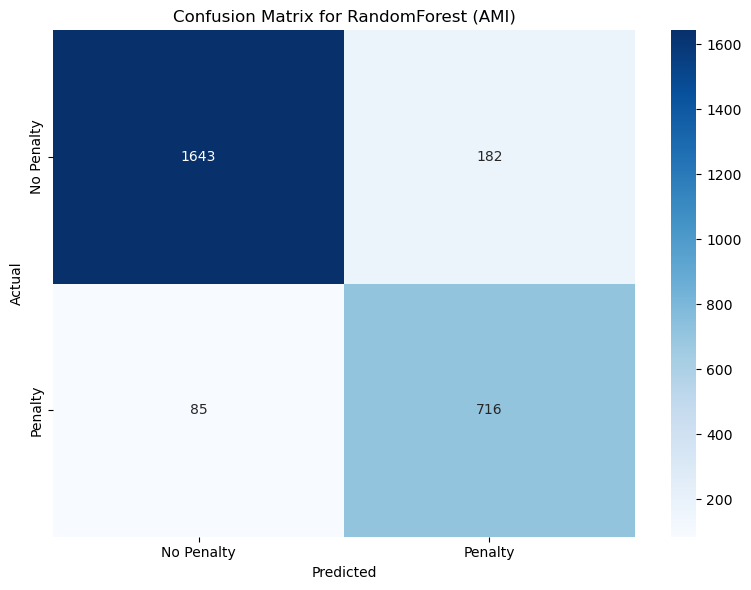

--- End of RandomForest Pipeline for AMI ---

--- Tuning and Evaluating GradientBoosting for AMI ---
Best Parameters found for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 200}
Best ROC AUC score on validation sets: 0.97

--- Final Evaluation for Tuned GradientBoosting on Test Set ---
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

  No Penalty       0.96      0.89      0.93      1825
     Penalty       0.79      0.92      0.85       801

    accuracy                           0.90      2626
   macro avg       0.88      0.91      0.89      2626
weighted avg       0.91      0.90      0.90      2626



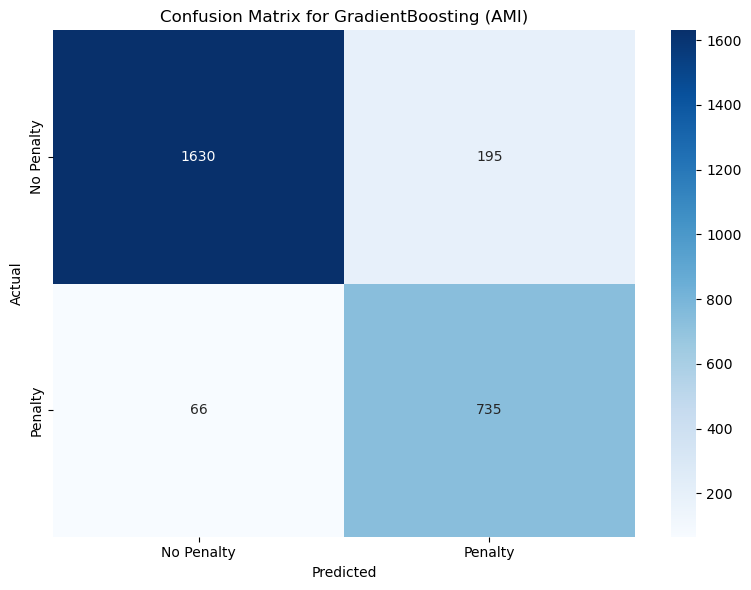

--- End of GradientBoosting Pipeline for AMI ---

--- Advanced Modeling Pipeline for AMI Completed ---


In [11]:
run_advanced_model_pipeline(df, 'AMI')